In [37]:
# Imports

import boto3
import requests
from folium import Map, Marker, GeoJson
from folium.plugins import MarkerCluster
import pandas as pd
import ast
import matplotlib.pyplot as plt

import pydeck

from folium import Map, Marker, GeoJson
from folium.plugins import MarkerCluster
import branca.colormap as cm
from branca.colormap import linear
import folium

import seaborn as sns

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import matplotlib.gridspec as gridspec

from PIL import Image as pilim

%matplotlib inline

In [12]:
def boto_s3_client():
    """
    Boto client
    """
    response = requests.get("https://cct-ds-code-challenge-input-data.s3.af-south-1.amazonaws.com/ds_code_challenge_creds.json").json()

    return boto3.client('s3',
                        aws_access_key_id=response['s3']['access_key'],
                        aws_secret_access_key=response['s3']['secret_key'],
                        region_name='af-south-1')

In [13]:
s3 = boto_s3_client()

In [14]:
resp = s3.select_object_content(Bucket='cct-ds-code-challenge-input-data',
                                Key='sr_hex.csv.gz',
                                ExpressionType='SQL',
                                Expression="""
                                           SELECT
                                               *
                                           FROM s3object s
                                           """,
                                InputSerialization={
                                    'CSV': {
                                        'FileHeaderInfo': 'USE', 
                                        'RecordDelimiter': '\n',
                                        "FieldDelimiter": ",",
                                        # 'AllowQuotedRecordDelimiter': True
                                    },
                                    "CompressionType": "GZIP"
                                },
                                OutputSerialization={'JSON': {'RecordDelimiter': ','}
                                })

In [49]:
 # Loop through the chunks of data returned by the S3 SELECT command and print them to the console
result_stream = []
for event in resp['Payload']:
    if 'Records' in event:
        try:
            result_stream.append(event['Records']['Payload'].decode('utf-8'))
            result_stream = ast.literal_eval(''.join(result_stream))
        except:
            pass
df = pd.DataFrame.from_dict(result_stream)
df = df.reset_index(drop=True)
display(df.head())

""


In [16]:
df['directorate'].unique()

array(['URBAN MOBILITY', '', 'WATER AND SANITATION', 'ENERGY',
       'HUMAN SETTLEMENTS', 'URBAN WASTE MANAGEMENT', 'FINANCE',
       'COMMUNITY SERVICES AND HEALTH', 'SAFETY AND SECURITY',
       'CORPORATE SERVICES', 'ECONOMIC GROWTH'], dtype=object)

In [47]:
df.to_csv('sr.csv')

In [17]:
water_and_sanitation_directorate_df = df[df['directorate'] == 'WATER AND SANITATION']

In [18]:
water_and_sanitation_directorate_df.groupby('official_suburb')['reference_number'].count()


official_suburb
ADRIAANSE                         1
AMANDA GLEN                       1
AMANDELRUG                        1
ATHLONE                           4
AUSTINVILLE                       1
                                 ..
WOODSTOCK                         2
WP PARK                           1
WYNBERG                          10
ZEEKOEVLEI                        2
ZEVENWACHT RETIREMENT VILLAGE     1
Name: reference_number, Length: 280, dtype: int64

In [19]:
grouped_data = water_and_sanitation_directorate_df.groupby('official_suburb').reference_number.value_counts()
filtered_data = grouped_data.loc[grouped_data >= 7]

Text(0.5, 1.0, 'Distribution of service requests per suburb')

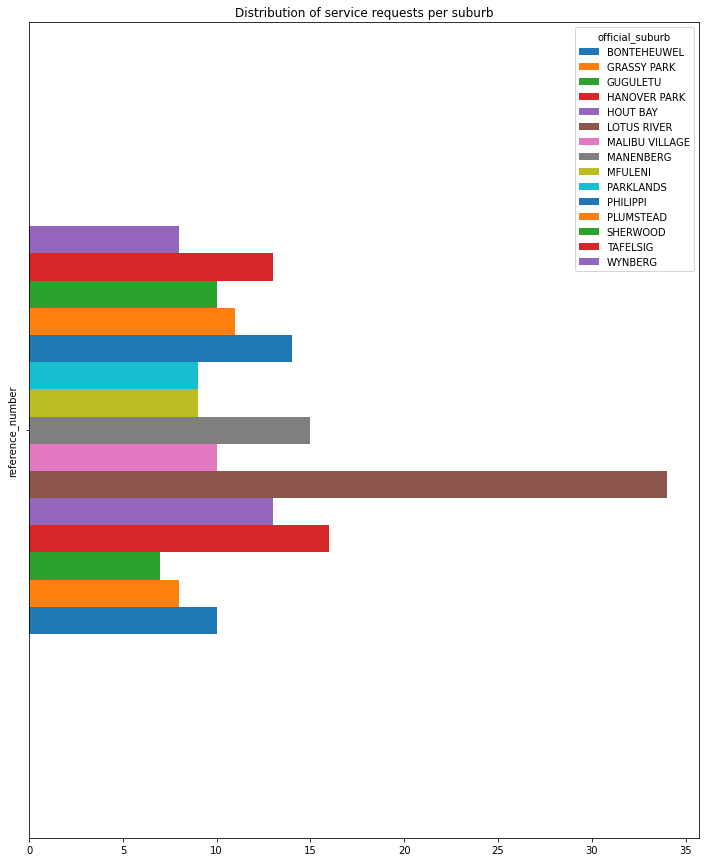

In [36]:
filtered_data.unstack(0).plot.barh(figsize=(12, 15))
plt.title("Distribution of service requests per suburb")

In [38]:
def base_empty_map():
    """Prepares a folium map centered in a central GPS point of Cape Town"""
    m = Map(location = [-33.92, 18.42],
            zoom_start = 9.5,
            tiles = "cartodbpositron",
            )
    return m

In [39]:
# quick visualization on map of raw data

m = base_empty_map()
mc = MarkerCluster()

gdf_dedup = water_and_sanitation_directorate_df.drop_duplicates(subset=["latitude", "longitude"])
print("Number of service requests around Cape Town", gdf_dedup.shape[0]) 

for i, row in gdf_dedup.iterrows():
    mk = Marker(location=[row["latitude"], row["longitude"]])
    mk.add_to(mc)

mc.add_to(m)
m

Number of service requests around Cape Town 893


In [40]:
steps = 5
color_map = cm.linear.RdYlGn_10.scale(0, 1).to_step(steps)

# in reverse order (green to red)
for i in range(steps-1, -1, -1):
    # would be fractional values, but we need them as RGB in [0,255]
    # also drop the alpha (4th element)
    print([int(255 * x) for x in color_map.colors[i][:-1]])

color_map

[0, 104, 55]
[117, 195, 100]
[235, 231, 139]
[246, 125, 74]
[165, 0, 38]


In [41]:
water_and_sanitation_directorate_df[["longitude", "latitude"]] = water_and_sanitation_directorate_df[["longitude", "latitude"]].astype(float)

/var/folders/y8/lmfzd5rj3pdgbq3ppc9f82_80000gp/T/ipykernel_86895/3240201014.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  water_and_sanitation_directorate_df[["longitude", "latitude"]] = water_and_sanitation_directorate_df[["longitude", "latitude"]].astype(float)


In [42]:
COLOR_SCALE = [
    [0, 104, 55],
    [117, 195, 100],
    [235, 231, 139],
    [246, 125, 74],
    [165, 0, 38]
]

layer = pydeck.Layer("HeatmapLayer",
                     data = water_and_sanitation_directorate_df,
                     opacity = 0.2,
                     get_position = ["longitude", "latitude"],
                     threshold = 0.05,
                     intensity = 1,
                     radiusPixels = 30,
                     pickable = False,
                     color_range=COLOR_SCALE
                    )

view = pydeck.data_utils.compute_view(water_and_sanitation_directorate_df[["longitude", "latitude"]])
view.zoom = 6

MAPBOX_TOKEN = "pk.eyJ1IjoibW95bzg5IiwiYSI6ImNsZ2E3MWkzaDB3YnkzZXJ2ZGt4cGFsOHYifQ.L7JRJqGOujycP6IEyDoQug"

r = pydeck.Deck(
    layers=[layer],
    map_style='mapbox://styles/mapbox/light-v10',
    initial_view_state = view,
    api_keys = {'mapbox': MAPBOX_TOKEN},
)

r.show()

DeckGLWidget(carto_key=None, custom_libraries=[], google_maps_key=None, json_input='{\n  "initialViewState": {…

In [43]:
r.to_html('demo.html')

<Axes: >

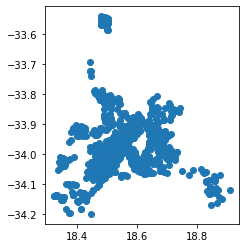

In [44]:
import geopandas as gpd
water_and_sanitation_directorate = gpd.GeoDataFrame(
    water_and_sanitation_directorate_df, geometry=gpd.points_from_xy(x=water_and_sanitation_directorate_df.longitude, 
                                    y=water_and_sanitation_directorate_df.latitude)
)
water_and_sanitation_directorate.plot()

In [45]:
print(water_and_sanitation_directorate.crs)

None


In [46]:
water_and_sanitation_directorate = water_and_sanitation_directorate.set_crs(epsg=4326)
water_and_sanitation_directorate.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [24]:
water_and_sanitation_directorate.explore()

In [48]:
import folium

# Create map centered on Cape Town
m = folium.Map(location=[-33.92, 18.42], zoom_start=10)

# Add markers for each data point
for _, row in water_and_sanitation_directorate_df.iterrows():
    folium.Marker(location=[row['latitude'], row['longitude']], popup=row['official_suburb']).add_to(m)

# Display map
m